In [1]:
import sys
base_path = 'C:\\github\\aide-analysis'
sys.path.append(base_path)

from core.config import Config
config = Config()
config.RAWDATA_PATH

# 사전처리
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import glob
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings(action='ignore')

# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

# Pandas Float 자릿수 표시 제한
pd.options.display.float_format = '{:.2f}'.format

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

### 1. 거래량과 미분양 정말로 관계가 없을까?

In [61]:
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
import datetime
bq = bigquery_client

# 아파트 전세 테이블 연도별 거래량
sql = f"""
SELECT contractDate, 
       count(*) AS cnt
FROM `aidepartners.aide.transaction_price_apartment_rent`
WHERE pnuCode LIKE '42%'
GROUP BY contractDate
ORDER BY contractDate ASC
"""
df = bq.query(sql).to_dataframe()
transaction = df.copy()

# 타입변경
transaction['contractDate'] = pd.to_datetime(transaction['contractDate'],format = '%Y-%m-%d')

# 연도 컬럼 생성
transaction['year'] = transaction['contractDate'].dt.year

# 인덱스 설정
transaction = pd.DataFrame(transaction.groupby('year')['cnt'].sum()).reset_index()


# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) FROM aide.unsold_sigungu
WHERE sigunguName !='계'
	  AND sidoCode = '42'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()

# 거래량 데이터와 연도 통일
transaction = transaction.loc[6:,['year','cnt']].reset_index(drop = True)

# 컬럼명 변경
unsold = unsold.rename(columns = {'SUM(unsold)':'unsold'})


# Merge
dataset = pd.merge(transaction, unsold,on = 'year', how = 'inner')

# 정규화
dataset['cnt'] = dataset['cnt'].apply(lambda x: (x/18599)-1)
dataset['unsold'] = dataset['unsold'].apply(lambda x: (x/35196)-1)
dataset['unsold'] = dataset['unsold'].apply(lambda x:round(x,2))

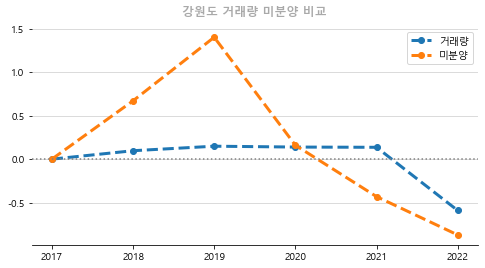

In [64]:
# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(dataset['year'],dataset['cnt'],"o--",label = '거래량',lw=3)
ax.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=3)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title("강원도 거래량 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)



ax.legend()

1. 이론적으로 거래량과 미분양은 상관관계가 별로 없다라는것을 시각화를 통해 확인

2. 미분양은 공급량과의 관계가 당연히 많지 않을까?(주택공급과 관련된 데이터 부재 -> 주거용 건축물 착공데이터 탐색)

3. 2019년 서울시 미분양이 많았는데 왜 그럴까?

### 2. 미분양과 전세증감률 관계

#### 확인해야할 사항
- 전세증감에서 year별로 그룹핑해서 SUM이 올바른것인가?
- 정규화의 방법

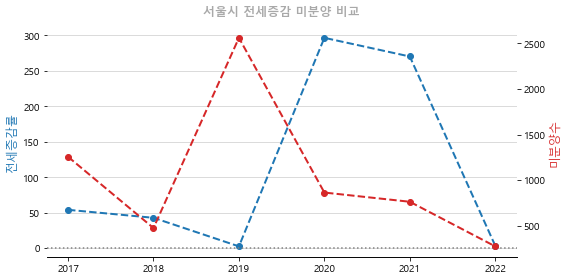

In [195]:
from src.openapi import KakaoLocalAPI as kakao
add_list = [
    "잠원동22-10",
    "경기도 용인시 기흥구 보정로 87",
    "경기도 수원시 팔달구 인계동 1111",
    "세종특별자치시 한누리대로 2130 세종특별시청",
    "탄현동 121",
    "지포리 138",
    "신안리 183",
    "홍제동 1037",
    "장락동 1029",
    "읍내동 25-6",
    "남장리 515",
    "도량동 222",
    "원리 892",
    "달천동 1-5",
    "서문리 218-11",
    "북변리 179-1",
    "주청리 120-4",
    "송월동 660"
]

docs = kakao.search_address('잠원동22-10')


# 시도/ 시군구/ 행정동 코드 추출
sidoCode = docs["documents"][0]["address"]["h_code"][:2]

# 행정구역 명칭
sido_ = docs["documents"][0]["address"]["region_1depth_name"]

# sidoCode ='11'
# sido_ = '서울'

sql3= f"""
SELECT YEAR(date) AS year, SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode LIKE '{sidoCode}%'
GROUP BY YEAR(date) 
order by YEAR(date)
"""
kb = db.read_table(sql3)
kb=kb.iloc[9:]

# 정규화 파라미터
norm = kb['jeonseChangeRate'].iloc[0]

# 정규화
#kb['jeonseChangeRate'] = kb['jeonseChangeRate'].apply(lambda x:(x/norm)-1)



# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) AS unsold FROM aide.unsold_sigungu
WHERE sigunguName !='계'
	  AND sidoCode = '{sidoCode}'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()
#unsold['unsold'] = unsold['unsold'].apply(lambda x: round((x/unsold['unsold'].iloc[0])-1,2))

dataset = pd.merge(kb, unsold, on = 'year', how = 'inner')

# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.set_ylabel('전세증감률',fontsize = 12, color = 'tab:blue')
ax.plot(dataset['year'],dataset['jeonseChangeRate'],"o--",label = '전세증감률',lw=2,color = 'tab:blue')


ax2 = ax.twinx()
ax2.set_ylabel('미분양수', fontsize = 12, color = 'tab:red')
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2,color = 'tab:red')


# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sido_}시 전세증감 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)


fig.tight_layout()
plt.show()

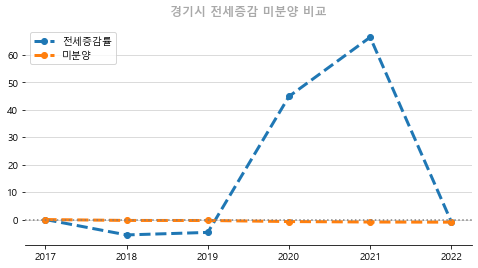

In [191]:
from src.openapi import KakaoLocalAPI as kakao


sql3= f"""
SELECT YEAR(date) AS year, SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode LIKE '{sidoCode}%'
GROUP BY YEAR(date) 
order by YEAR(date)
"""
kb = db.read_table(sql3)
kb=kb.iloc[9:]

# 정규화 파라미터
norm = kb['jeonseChangeRate'].iloc[0]

# 정규화
kb['jeonseChangeRate'] = kb['jeonseChangeRate'].apply(lambda x:(x/norm)-1)



# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) AS unsold FROM aide.unsold_sigungu
WHERE sigunguName !='계'
	  AND sidoCode = '{sidoCode}'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()
unsold['unsold'] = unsold['unsold'].apply(lambda x: round((x/unsold['unsold'].iloc[0])-1,2))

dataset = pd.merge(kb, unsold, on = 'year', how = 'inner')

# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(dataset['year'],dataset['jeonseChangeRate'],"o--",label = '전세증감률',lw=3)
ax.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=3)
# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sido_}시 전세증감 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)



ax.legend()

이슈 : 어떻게 정규화를 할것인가

In [158]:
sql3= f"""
SELECT YEAR(date) AS year, SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode LIKE '{sidoCode}%'
GROUP BY YEAR(date) 
order by YEAR(date)
"""
kb = db.read_table(sql3)
kb=kb.iloc[9:]
kb

,year,jeonseChangeRate
9,2017,54.03
10,2018,42.77
11,2019,2.47
12,2020,296.60
13,2021,270.28
14,2022,3.42


In [159]:
# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) AS unsold FROM aide.unsold_sigungu
WHERE sigunguName !='계'
	  AND sidoCode = '{sidoCode}'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()
unsold

,year,unsold
0,2017,1256
1,2018,475
2,2019,2560
3,2020,864
4,2021,763
5,2022,274


### 3. (매매증감률과 미분양) + (매매증감 + 전세증감 비교)

### 4. 주택인허가 활용(API) -> 3번진행 후 진행

In [39]:
# 주택인허가 데이터 OPEN API
import requests
import json
import xmltodict

endPoint = "http://apis.data.go.kr/1611000/HsPmsService"
key = ""
operationName = "getHpBasisOulnInfo"
sigunguCode = '11710'
numOfRows = '10'
pageNo = '1'

url = f"{endPoint}/{operationName}?sigunguCd={sigunguCode}&bjdongCd={bdongCode}&numOfRows={numOfRows}&pageNo={pageNo}&ServiceKey={key}"
print(url)

result = xmltodict.parse(requests.get(url).text)
result = json.loads(json.dumps(result))
result 

http://apis.data.go.kr/1611000/HsPmsService/getHpBasisOulnInfo?sigunguCd=11710&bjdongCd=10300&numOfRows=10&pageNo=1&ServiceKey=Hq2wnub/iZKqw9lRb26b35ZxOJG03vwhhrirESSfYKsNYdEsj0li7vQaFogysBhKvyHtfXCxBvzY8VLFxz8ZFQ==


{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL SERVICE.'},
  'body': {'items': {'item': [{'apprvDay': '20080808',
      'bjdongCd': '10300',
      'bldNm': None,
      'block': None,
      'bun': '0508',
      'crtnDay': '20120218',
      'demolEndDay': None,
      'demolExtngDay': None,
      'demolExtngGbCd': None,
      'demolExtngGbCdNm': None,
      'demolStrtDay': None,
      'ji': '0000',
      'lot': None,
      'mainBldCnt': '0',
      'mgmHsrgstPk': '11710-100006240',
      'platGbCd': '0',
      'platPlc': '서울특별시 송파구 풍납동 508번지',
      'purpsCd': None,
      'purpsCdNm': None,
      'rnum': '1',
      'sigunguCd': '11710',
      'splotNm': None,
      'stcnsDay': None,
      'stcnsSchedDay': None,
      'strctCd': None,
      'strctCdNm': None,
      'totArea': '0',
      'totHhldCnt': '0',
      'useInsptDay': None,
      'useInsptSchedDay': None},
     {'apprvDay': '19951226',
      'bjdongCd': '10300',
      'bldNm': '풍납동 삼화재건축',
      'block': None,
   

In [56]:
result['response']['body']['items']['item'][0]

{'apprvDay': '20080808',
 'bjdongCd': '10300',
 'bldNm': None,
 'block': None,
 'bun': '0508',
 'crtnDay': '20120218',
 'demolEndDay': None,
 'demolExtngDay': None,
 'demolExtngGbCd': None,
 'demolExtngGbCdNm': None,
 'demolStrtDay': None,
 'ji': '0000',
 'lot': None,
 'mainBldCnt': '0',
 'mgmHsrgstPk': '11710-100006240',
 'platGbCd': '0',
 'platPlc': '서울특별시 송파구 풍납동 508번지',
 'purpsCd': None,
 'purpsCdNm': None,
 'rnum': '1',
 'sigunguCd': '11710',
 'splotNm': None,
 'stcnsDay': None,
 'stcnsSchedDay': None,
 'strctCd': None,
 'strctCdNm': None,
 'totArea': '0',
 'totHhldCnt': '0',
 'useInsptDay': None,
 'useInsptSchedDay': None}